
# 03 - Modular Enhancements

This notebook mirrors the Part 3 experiments but keeps the code lightweight by
relying on helper modules in `src/`.


## Imports & shared setup

In [1]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import Markdown, display
from dataclasses import replace, dataclass

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.models.birnn import BiLSTMClassifier, BiGRUClassifier
from src.models.cnn import CNNTextClassifier
from src.training import (
    RNNExperimentConfig,
    train_rnn_model,
    build_dataloaders_and_vocab,
    run_model_experiment,
    summarise_run,
)
from src.evaluation import evaluate_model, topic_accuracy_table, classification_report_table
from src.plotting import plot_training_curves, latex_set_size, plot_barplot, plot_support_and_f1_by_topic

SEED = 7
sns.set_theme(style="whitegrid")

## Data & embeddings

In [2]:
data_config = load_data_config(Path('configs/data.yaml'))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

In [3]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name='6B',
    dim=100,
    trainable=True,
    random_seed=SEED,
)
embedding_tensor = torch.tensor(embedding_result.matrix, dtype=torch.float32)

C:\Users\OWNER\anaconda3\envs\torch2\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\OWNER\anaconda3\envs\torch2\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Shared experiment configuration

In [4]:
base_config = RNNExperimentConfig(
    epochs=15,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0,
    pooling='last_hidden',
    optimizer='adam',
    early_stopping_patience=3,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaders, label_to_index = build_dataloaders_and_vocab(base_config, splits, vocab_report.vocabulary)
records = {'rows': [], 'histories': {}, 'evaluations': {}, 'label_maps': {}}

## Baseline RNN

Baseline test accuracy: 0.822

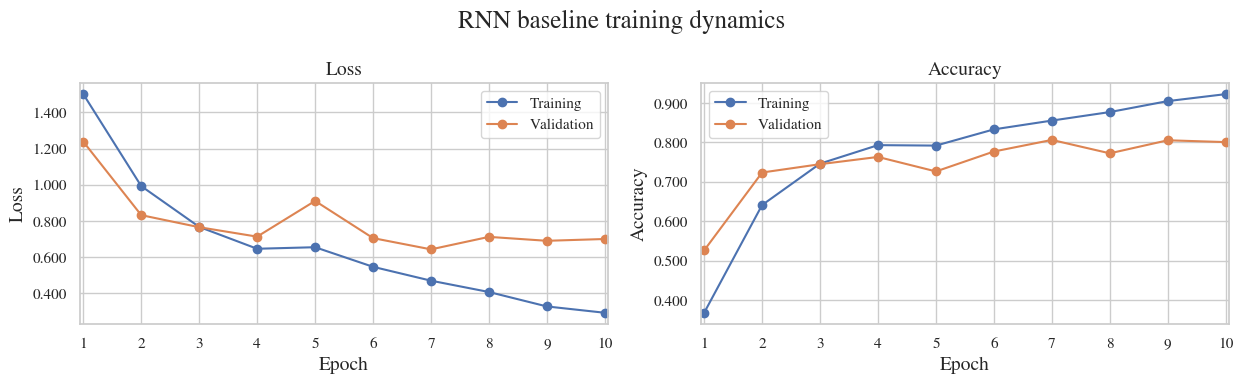

In [5]:
b_hist, b_model, b_label_map, b_loaders = train_rnn_model(
    base_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
    device=device,
)
b_eval = evaluate_model(b_model, b_loaders.test, device=device)
records['histories']['rnn_baseline'] = b_hist
records['evaluations']['rnn_baseline'] = b_eval
records['label_maps']['rnn_baseline'] = b_label_map
records['rows'].append(summarise_run('rnn_baseline', b_hist, b_eval.accuracy))
plot_training_curves(
    b_hist,
    title='RNN baseline training dynamics',
    output_path=Path('plots/part3_rnn_baseline_curves.png'),
    figure_fraction=1
)
display(Markdown(f"Baseline test accuracy: {b_eval.accuracy:.3f}"))

## biLSTM

biLSTM test accuracy: 0.882

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

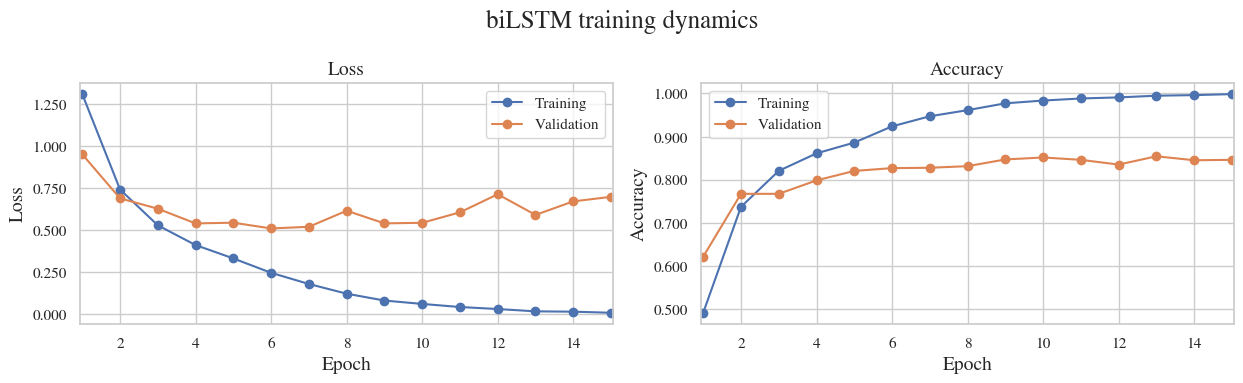

In [6]:
hist_bilstm, model_bilstm, eval_bilstm = run_model_experiment(
    'bilstm',
    model_builder=lambda: BiLSTMClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bilstm'] = hist_bilstm
records['evaluations']['bilstm'] = eval_bilstm
records['label_maps']['bilstm'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bilstm', hist_bilstm, eval_bilstm.accuracy))
display(Markdown(f"biLSTM test accuracy: {eval_bilstm.accuracy:.3f}"))
plot_training_curves(
    hist_bilstm,
    title='biLSTM training dynamics',
    output_path=Path('plots/part3_bilstm_curves.png'),
    figure_fraction=1
)

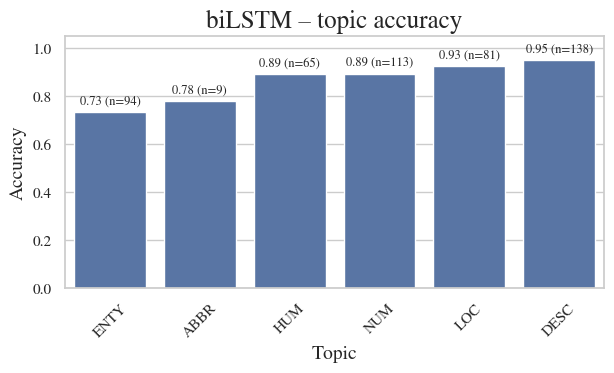

In [7]:
bilstm_topic_df = topic_accuracy_table(eval_bilstm, records['label_maps']['bilstm'])
sorted_bilstm_topics = bilstm_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bilstm_topics['label'],
    y=sorted_bilstm_topics['accuracy'],
    title='biLSTM – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bilstm_topics['accuracy'],
        sorted_bilstm_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bilstm_topic_accuracy.png', dpi=300)
plt.show()


## biGRU

biGRU test accuracy: 0.886

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

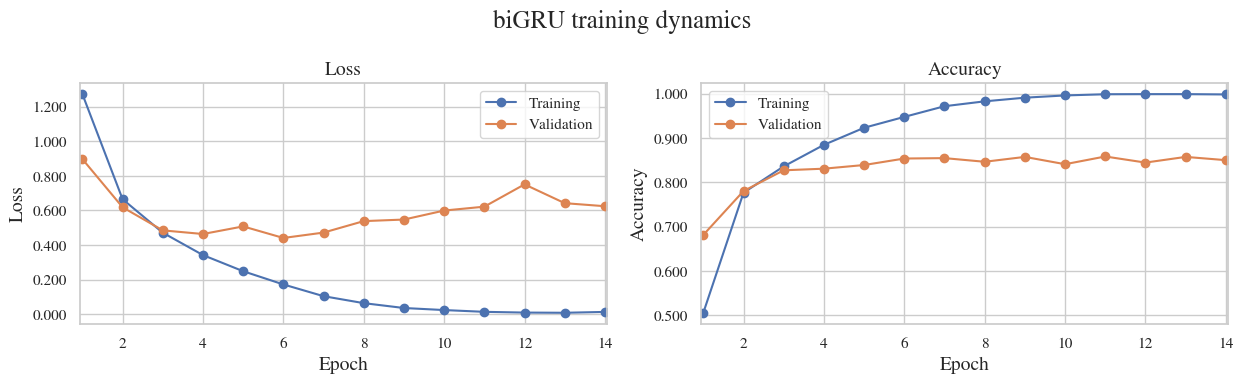

In [8]:
hist_bigru, model_bigru, eval_bigru = run_model_experiment(
    'bigru',
    model_builder=lambda: BiGRUClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bigru'] = hist_bigru
records['evaluations']['bigru'] = eval_bigru
records['label_maps']['bigru'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bigru', hist_bigru, eval_bigru.accuracy))
display(Markdown(f"biGRU test accuracy: {eval_bigru.accuracy:.3f}"))
plot_training_curves(
    hist_bigru,
    title='biGRU training dynamics',
    output_path=Path('plots/part3_bigru_curves.png'),
    figure_fraction=1

)

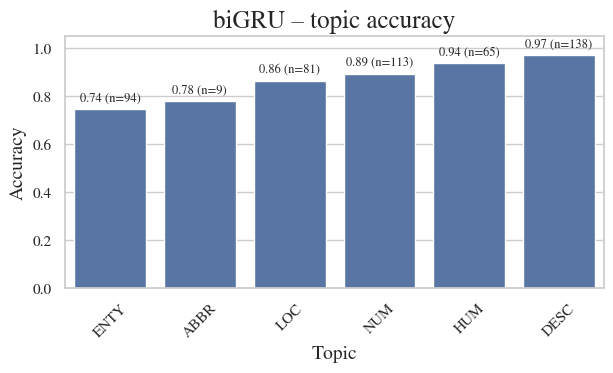

In [9]:
bigru_topic_df = topic_accuracy_table(eval_bigru, records['label_maps']['bigru'])
sorted_bigru_topics = bigru_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bigru_topics['label'],
    y=sorted_bigru_topics['accuracy'],
    title='biGRU – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bigru_topics['accuracy'],
        sorted_bigru_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bigru_topic_accuracy.png', dpi=300)
plt.show()


## CNN

CNN test accuracy: 0.890

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

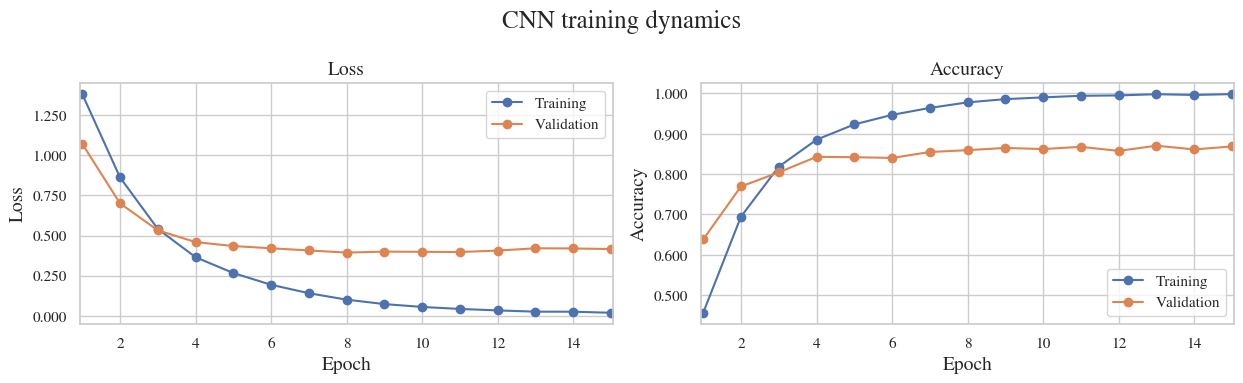

In [10]:
cnn_config = replace(base_config, dropout=0.5, weight_decay=0.0, grad_clip=0.0)
hist_cnn, model_cnn, eval_cnn = run_model_experiment(
    'cnn',
    model_builder=lambda: CNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        dropout=cnn_config.dropout,
    ),
    config=cnn_config,
    loaders=loaders,
    device=device,
)
records['histories']['cnn'] = hist_cnn
records['evaluations']['cnn'] = eval_cnn
records['label_maps']['cnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('cnn', hist_cnn, eval_cnn.accuracy))
display(Markdown(f"CNN test accuracy: {eval_cnn.accuracy:.3f}"))
plot_training_curves(
    hist_cnn,
    title='CNN training dynamics',
    output_path=Path('plots/part3_cnn_curves.png'),
    figure_fraction=1
    
)

## Further Model Improvement

C:\Users\OWNER\anaconda3\envs\torch2\Lib\site-packages\torch\nn\functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


RCNN test accuracy: **0.920**

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

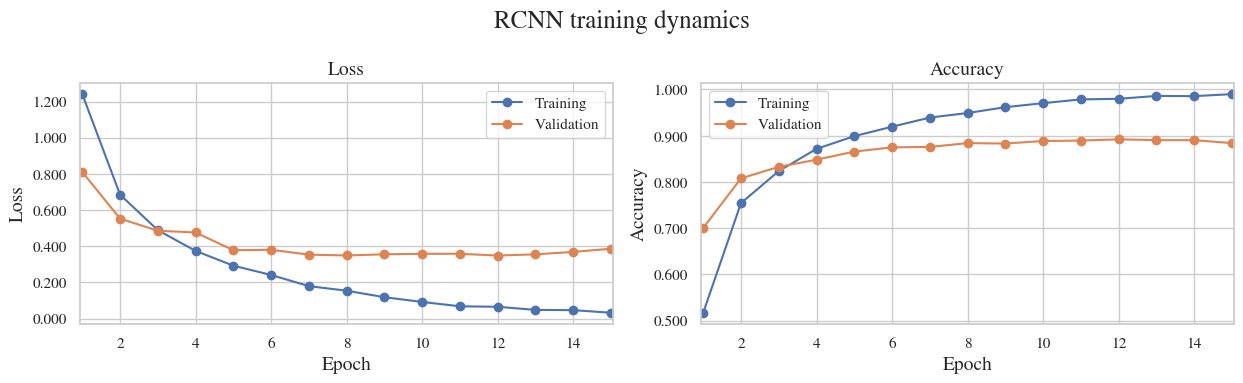

In [11]:
from src.models.rcnn import RCNNTextClassifier

hist_rcnn, model_rcnn, eval_rcnn = run_model_experiment(
    'rcnn',
    model_builder=lambda: RCNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
        padding_idx=0,
        multisample_dropout=4,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)

records['histories']['rcnn'] = hist_rcnn
records['evaluations']['rcnn'] = eval_rcnn
records['label_maps']['rcnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('rcnn', hist_rcnn, eval_rcnn.accuracy))

display(Markdown(f"RCNN test accuracy: **{eval_rcnn.accuracy:.3f}**"))
plot_training_curves(
    hist_rcnn,
    title='RCNN training dynamics',
    output_path=Path('plots/part3_3_rcnn_curves.png'),
    figure_fraction=1
)


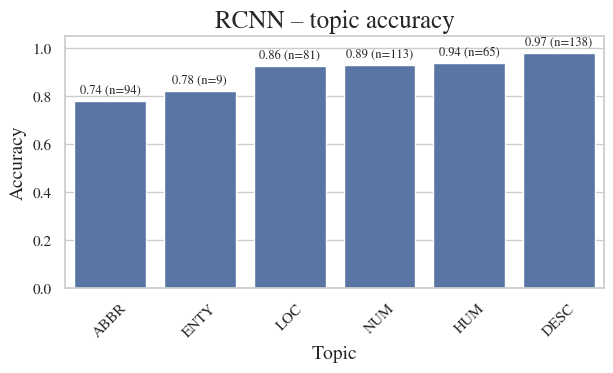

In [12]:
rcnn_topic_df = topic_accuracy_table(eval_rcnn, records['label_maps']['rcnn'])
sorted_rcnn_topics = rcnn_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_rcnn_topics['label'],
    y=sorted_rcnn_topics['accuracy'],
    title='RCNN – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14) 
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bigru_topics['accuracy'],
        sorted_bigru_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:   
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_rcnn_topic_accuracy.png', dpi=300)
plt.show()

## Summary & comparison

,best_epoch,val_accuracy,test_accuracy
name,,,
rcnn,12,0.891842,0.920
cnn,13,0.869844,0.890
bigru,11,0.857929,0.886
bilstm,13,0.854262,0.882
rnn_baseline,7,0.805683,0.822


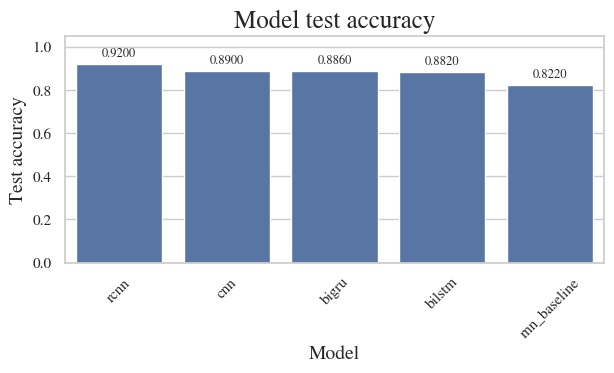

Best model: **rcnn** (test accuracy 0.920)

,label,accuracy,support
0,ABBR,0.777778,9
2,ENTY,0.819149,94
4,LOC,0.925926,81
5,NUM,0.929204,113
3,HUM,0.938462,65
1,DESC,0.978261,138


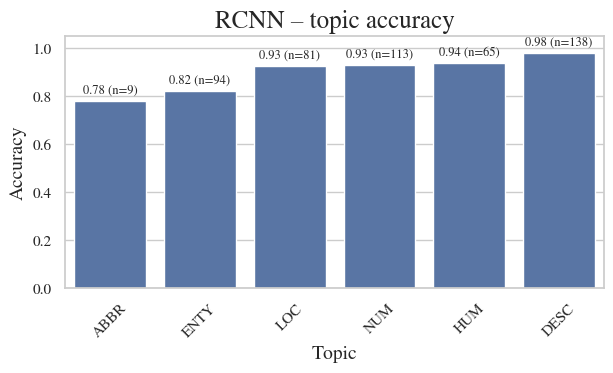

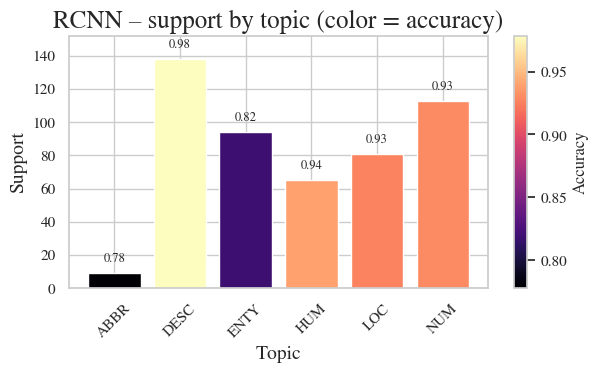

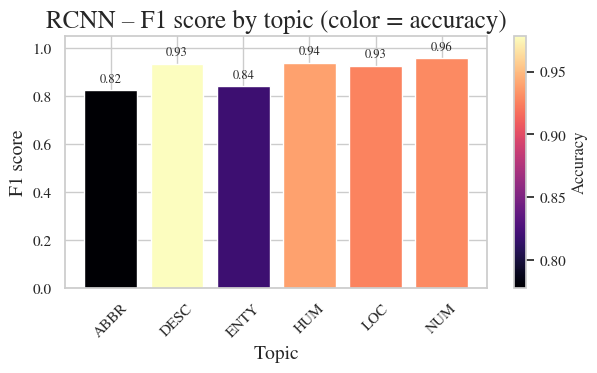

,precision,recall,f1-score,support
accuracy,0.920000,0.920000,0.920000,0.92
macro avg,0.914860,0.894796,0.903768,500.00
weighted avg,0.921025,0.920000,0.919598,500.00


In [13]:
comparison_df = pd.DataFrame(records['rows']).set_index('name').sort_values('test_accuracy', ascending=False)
display(comparison_df)

fig, ax = plot_barplot(
    x=comparison_df.index,
    y=comparison_df['test_accuracy'],
    title='Model test accuracy',
)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Test accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
label_values = [f"{score:.4f}" for score in comparison_df['test_accuracy']]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, label_values):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
plt.show()

best_row = comparison_df.iloc[0]
best_name = best_row.name
best_eval = records['evaluations'][best_name]
best_history = records['histories'][best_name]
best_label_map = records['label_maps'][best_name]
best_accuracy = float(best_row['test_accuracy'])
display(Markdown(f"Best model: **{best_name}** (test accuracy {best_accuracy:.3f})"))

best_topic_df = topic_accuracy_table(best_eval, best_label_map)
sorted_best_topics = best_topic_df.sort_values('accuracy')
display(sorted_best_topics)

fig, ax = plot_barplot(
    x=sorted_best_topics['label'],
    y=sorted_best_topics['accuracy'],
    title=f"{best_name.upper()} – topic accuracy",
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
topic_labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_best_topics['accuracy'],
        sorted_best_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, topic_labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig(f"plots/part3_{best_name}_topic_accuracy.png", dpi=300)
plt.show()

best_report_df = classification_report_table(best_eval, best_label_map)
label_rows = best_report_df.loc[~best_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])].copy()
if 'accuracy' not in label_rows.columns:
    label_rows['accuracy'] = label_rows.get('recall', 0.0)

plot_support_and_f1_by_topic(
    label_rows,
    support_title=f"{best_name.upper()} – support by topic (color = accuracy)",
    f1_title=f"{best_name.upper()} – F1 score by topic (color = accuracy)",
    xlabel='Topic',
    support_ylabel='Support',
    f1_ylabel='F1 score',
    support_output_path=f"plots/part3_{best_name}_classification_support.png",
    f1_output_path=f"plots/part3_{best_name}_classification_f1.png",
)

averages_df = best_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_report_df.columns if col in ['precision', 'recall', 'f1-score', 'support']],
]
display(averages_df)


## Targeted Improvement Strategies

Identified Weaker Topics: ENTY and ABBR

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from src.models.rcnn import RCNNTextClassifier

PAD_IDX = 0

def unpack_batch_rcnn(batch, device, pad_idx=PAD_IDX):
    tokens = None
    lengths = None
    labels = None

    if isinstance(batch, dict):
        t = batch.get("text", batch.get("tokens", None))
        if isinstance(t, (tuple, list)) and len(t) == 2:
            tokens, lengths = t
        else:
            tokens = t
        for k in ("label", "labels", "y", "target", "targets"):
            if k in batch:
                labels = batch[k]
                break

    elif isinstance(batch, (tuple, list)):
        if len(batch) == 2:
            tokens, labels = batch
        elif len(batch) >= 3:
            tokens, lengths, labels = batch[0], batch[1], batch[2]

    else:
        for name in ("text", "tokens", "inputs", "input_ids", "x"):
            if hasattr(batch, name):
                tokens = getattr(batch, name)
                break
        for name in ("label", "labels", "y", "target", "targets"):
            if hasattr(batch, name):
                labels = getattr(batch, name)
                break
        for name in ("lengths", "lens", "seq_lengths"):
            if hasattr(batch, name):
                lengths = getattr(batch, name)
                break

        tensor_attrs = {
            n: getattr(batch, n)
            for n in dir(batch)
            if not n.startswith("_")
            and hasattr(batch, n)
            and torch.is_tensor(getattr(batch, n))
        }

        if tokens is None:
            for n, t in tensor_attrs.items():
                if t.dim() == 2 and t.dtype in (torch.long, torch.int64, torch.int32):
                    tokens = t
                    break

        if labels is None and tokens is not None:
            B = tokens.size(0)
            for n, t in tensor_attrs.items():
                if (
                    t.dim() == 1
                    and t.dtype in (torch.long, torch.int64, torch.int32)
                    and t.size(0) == B
                ):
                    labels = t
                    break

        if lengths is None and tokens is not None:
            B = tokens.size(0)
            for n, t in tensor_attrs.items():
                if (
                    t.dim() == 1
                    and t.size(0) == B
                    and t.dtype in (torch.long, torch.int64, torch.int32)
                    and (labels is None or not torch.equal(t, labels))
                ):
                    lengths = t
                    break

    tokens = tokens.to(device)
    labels = labels.to(device)

    if lengths is None:
        lengths = (tokens != pad_idx).sum(dim=1)
    lengths = lengths.to(device)

    return tokens, lengths, labels

def split_train_test(loaders):
    if isinstance(loaders, dict):
        train = loaders.get("train") or loaders.get("train_loader")
        test = loaders.get("test") or loaders.get("test_loader")
    else:
        def pick(*names):
            for n in names:
                if hasattr(loaders, n):
                    return getattr(loaders, n)
            return None

        train = pick("train", "train_loader", "train_dataloader")
        test = pick("test", "test_loader", "test_dataloader")

    def ensure_iterable(dl, name):
        if callable(dl):
            dl = dl()
        return dl

    return ensure_iterable(train, "train"), ensure_iterable(test, "test")

def coarse_topic_accuracy_from_eval(eval_result, label_to_index):
    index_to_label = {idx: lbl for lbl, idx in label_to_index.items()}
    counts = {}

    y_true = eval_result["y_true"]
    y_pred = eval_result["y_pred"]

    for t, p in zip(y_true, y_pred):
        true_fine = index_to_label[int(t)]
        pred_fine = index_to_label[int(p)]

        true_coarse = true_fine.split(":")[0]
        pred_coarse = pred_fine.split(":")[0]

        if true_coarse not in counts:
            counts[true_coarse] = {"correct": 0, "total": 0}

        counts[true_coarse]["total"] += 1
        if pred_coarse == true_coarse:
            counts[true_coarse]["correct"] += 1

    rows = []
    order = ["ABBR", "ENTY", "NUM", "HUM", "LOC", "DESC"]
    for c in order:
        if c in counts:
            s = counts[c]
            acc = s["correct"] / s["total"] if s["total"] > 0 else 0.0
            rows.append({"label": c, "accuracy": acc, "support": s["total"]})
    for c, s in counts.items():
        if c not in order:
            acc = s["correct"] / s["total"] if s["total"] > 0 else 0.0
            rows.append({"label": c, "accuracy": acc, "support": s["total"]})

    return pd.DataFrame(rows)

### ENTY Improvement Strategy

In [15]:
def run_enty_rcnn_improved(
    loaders,
    device,
    label_to_index,
    embedding_tensor,
    base_config,
    enty_weight=2.0,
    alpha_fine=1.0,
    beta_coarse=1.0,
    model_name="rcnn_enty_improved",
):
    num_fine = len(label_to_index)
    index_to_label = {idx: lbl for lbl, idx in label_to_index.items()}

    coarse_labels = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]
    coarse_to_idx = {c: i for i, c in enumerate(coarse_labels)}

    fine_to_coarse = torch.empty(num_fine, dtype=torch.long)
    for fine_idx in range(num_fine):
        fine_lbl = index_to_label[fine_idx]
        coarse = fine_lbl.split(":")[0]
        fine_to_coarse[fine_idx] = coarse_to_idx[coarse]
    fine_to_coarse = fine_to_coarse.to(device)

    coarse_weights = torch.ones(len(coarse_labels), device=device)
    if "ENTY" in coarse_to_idx:
        coarse_weights[coarse_to_idx["ENTY"]] *= enty_weight

    model = RCNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=num_fine,
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
        padding_idx=PAD_IDX,
        multisample_dropout=4,
    ).to(device)

    train_loader, test_loader = split_train_test(loaders)

    num_epochs = getattr(base_config, "num_epochs", getattr(base_config, "n_epochs", 10))
    lr = getattr(base_config, "learning_rate", getattr(base_config, "lr", 1e-3))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_fine = nn.CrossEntropyLoss()
    nll_coarse = nn.NLLLoss(weight=coarse_weights)

    history = {"train_loss": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            tokens, lengths, labels = unpack_batch_rcnn(batch, device)

            optimizer.zero_grad()
            logits_fine = model(tokens, lengths)

            loss_fine = ce_fine(logits_fine, labels)

            y_coarse = fine_to_coarse[labels]

            log_probs_fine = F.log_softmax(logits_fine, dim=1)
            coarse_log_probs = []
            
            for c in range(len(coarse_labels)):
                mask = (fine_to_coarse == c)
                log_p_c = torch.logsumexp(log_probs_fine[:, mask], dim=1)
                coarse_log_probs.append(log_p_c.unsqueeze(1))
            coarse_log_probs = torch.cat(coarse_log_probs, dim=1)

            loss_coarse = nll_coarse(coarse_log_probs, y_coarse)

            loss = alpha_fine * loss_fine + beta_coarse * loss_coarse
            loss.backward()
            optimizer.step()

            total_loss += float(loss.item())
            n_batches += 1

        history["train_loss"].append(total_loss / max(1, n_batches))

    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            tokens, lengths, labels = unpack_batch_rcnn(batch, device)
            logits = model(tokens, lengths)
            preds = logits.argmax(dim=1)
            all_true.append(labels.cpu())
            all_pred.append(preds.cpu())

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()

    eval_result = {"y_true": y_true, "y_pred": y_pred}

    if "records" in globals() and isinstance(records, dict):
        records.setdefault("histories", {})
        records.setdefault("evals", {})
        records["histories"][model_name] = history
        records["evals"][model_name] = eval_result

    return history, model, eval_result

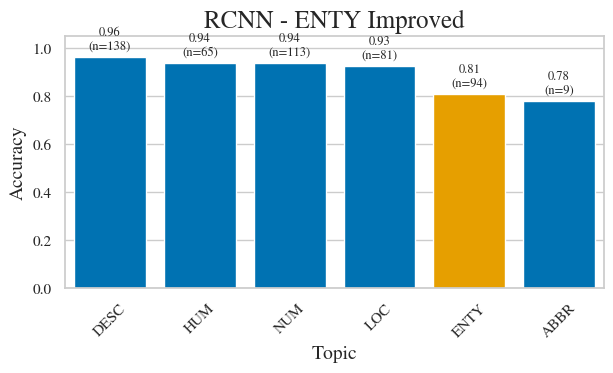

,label,accuracy,support
0,DESC,0.963768,138
1,HUM,0.938462,65
2,NUM,0.938053,113
3,LOC,0.925926,81
4,ENTY,0.808511,94
5,ABBR,0.777778,9


In [17]:
hist_enty_imp, model_enty_imp, eval_enty_imp = run_enty_rcnn_improved(
    loaders=loaders,
    device=device,
    label_to_index=label_to_index,
    embedding_tensor=embedding_tensor,
    base_config=base_config,
    enty_weight=2.0,
    alpha_fine=1.0,
    beta_coarse=1.0,
)

coarse_enty_imp_df = coarse_topic_accuracy_from_eval(eval_enty_imp, label_to_index)
coarse_enty_imp_df = coarse_enty_imp_df.sort_values("accuracy", ascending=False).reset_index(drop=True)

default_color = "#0072B2"
highlight_color = "#E69F00"

colors = [
    highlight_color if lbl == "ENTY" else default_color
    for lbl in coarse_enty_imp_df["label"]
]

fig, ax = plot_barplot(
    x=coarse_enty_imp_df["label"],
    y=coarse_enty_imp_df["accuracy"],
    title="RCNN - ENTY Improved",
)
for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

ax.set_xlabel("Topic", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_ylim(0, 1.05)

for rect, acc, supp in zip(ax.patches, coarse_enty_imp_df["accuracy"], coarse_enty_imp_df["support"]):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.02,
        f"{acc:.2f}\n(n={supp})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.show()
display(coarse_enty_imp_df)

### ABBR Improvement Strategy

In [18]:
def run_abbr_rcnn_improved(
    loaders,
    device,
    label_to_index,
    embedding_tensor,
    base_config,
    abbr_weight=10.0,
    dup_factor=50,
    model_name="rcnn_abbr_improved",
):
    
    num_fine = len(label_to_index)
    index_to_label = {idx: lbl for lbl, idx in label_to_index.items()}
    abbr_indices = [idx for lbl, idx in label_to_index.items() if lbl.startswith("ABBR:")]

    model = RCNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=num_fine,
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
        padding_idx=PAD_IDX,
        multisample_dropout=4,
    ).to(device)

    train_loader, test_loader = split_train_test(loaders)

    num_epochs = getattr(base_config, "num_epochs", getattr(base_config, "n_epochs", 10))
    lr = getattr(base_config, "learning_rate", getattr(base_config, "lr", 1e-3))
    
    class_weights = torch.ones(num_fine, device=device)
    for idx in abbr_indices:
        class_weights[idx] = abbr_weight
    ce = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            tokens, lengths, labels = unpack_batch_rcnn(batch, device)

            mask = torch.tensor(
                [int(y.item()) in abbr_indices for y in labels],
                device=device,
                dtype=torch.bool,
            )

            if mask.any():
                dup_tokens = tokens[mask].repeat((dup_factor, 1))
                dup_lengths = lengths[mask].repeat(dup_factor)
                dup_labels = labels[mask].repeat(dup_factor)

                tokens = torch.cat([tokens, dup_tokens], dim=0)
                lengths = torch.cat([lengths, dup_lengths], dim=0)
                labels = torch.cat([labels, dup_labels], dim=0)

            optimizer.zero_grad()
            logits = model(tokens, lengths)
            loss = ce(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += float(loss.item())
            n_batches += 1

        history["train_loss"].append(total_loss / max(1, n_batches))

    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            tokens, lengths, labels = unpack_batch_rcnn(batch, device)
            preds = model(tokens, lengths).argmax(dim=1)
            all_true.append(labels.cpu())
            all_pred.append(preds.cpu())

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()

    eval_result = {"y_true": y_true, "y_pred": y_pred}

    if "records" in globals() and isinstance(records, dict):
        records.setdefault("histories", {})
        records.setdefault("evals", {})
        records["histories"][model_name] = history
        records["evals"][model_name] = eval_result

    return history, model, eval_result

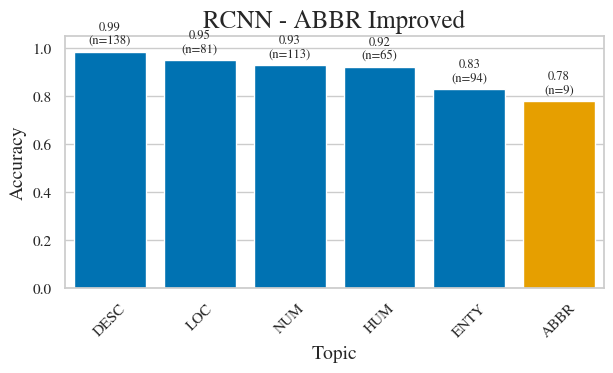

,label,accuracy,support
0,DESC,0.985507,138
1,LOC,0.950617,81
2,NUM,0.929204,113
3,HUM,0.923077,65
4,ENTY,0.829787,94
5,ABBR,0.777778,9


In [20]:
hist_abbr_imp, model_abbr_imp, eval_abbr_imp = run_abbr_rcnn_improved(
    loaders=loaders,
    device=device,
    label_to_index=label_to_index,
    embedding_tensor=embedding_tensor,
    base_config=base_config,
    abbr_weight=10.0,
    dup_factor=50,
)

coarse_abbr_imp_df = coarse_topic_accuracy_from_eval(eval_abbr_imp, label_to_index)
coarse_abbr_imp_df = coarse_abbr_imp_df.sort_values("accuracy", ascending=False).reset_index(drop=True)

default_color = "#0072B2"
highlight_color = "#E69F00"

colors = [
    highlight_color if lbl == "ABBR" else default_color
    for lbl in coarse_abbr_imp_df["label"]
]

fig, ax = plot_barplot(
    x=coarse_abbr_imp_df["label"],
    y=coarse_abbr_imp_df["accuracy"],
    title="RCNN - ABBR Improved",
)
for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

ax.set_xlabel("Topic", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_ylim(0, 1.05)

for rect, acc, supp in zip(ax.patches, coarse_abbr_imp_df["accuracy"], coarse_abbr_imp_df["support"]):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.02,
        f"{acc:.2f}\n(n={supp})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.show()
display(coarse_abbr_imp_df)

*Note* : There is no significant improvement in the ABBR category despite implementing oversampling and class weighting strategies, as the pool of samples for the ABBR category is too small. Further gains in accuracy would require more ABBR-labelled data rather than architectural modifications.
